# sumaryzacja tekstu

In [1]:
from google.colab import drive


drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [2]:
!nvidia-smi

Sat Jan 31 15:29:52 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   56C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
!pip install "datasets<3.0.0"


  Using cached datasets-2.21.0-py3-none-any.whl.metadata (21 kB)
Using cached datasets-2.21.0-py3-none-any.whl (527 kB)
  Attempting uninstall: datasets
    Found existing installation: datasets 4.3.0
    Uninstalling datasets-4.3.0:
      Successfully uninstalled datasets-4.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
unsloth-zoo 2026.1.4 requires datasets!=4.0.*,!=4.1.0,<4.4.0,>=3.4.1, but you have datasets 2.21.0 which is incompatible.
trl 0.24.0 requires datasets>=3.0.0, but you have datasets 2.21.0 which is incompatible.


In [4]:
!pip install bert-extractive-summarizer

In [5]:
!pip install pytorch-ignite
!pip install torchmetrics

## importowanie datesetu

In [6]:
from datasets import load_dataset


ds = load_dataset("EdinburghNLP/xsum", trust_remote_code=True)
ds= ds.filter(lambda example: len(example["document"]) < 1500)
split_result = ds["test"].train_test_split(test_size=2, seed=42)
shots = split_result["test"]
ds["test"] = split_result["train"]

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [7]:
print(ds)
print(shots)

DatasetDict({
    train: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 84554
    })
    validation: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 4705
    })
    test: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 4689
    })
})
Dataset({
    features: ['document', 'summary', 'id'],
    num_rows: 2
})


In [8]:
from summarizer import Summarizer
model_bertsum = Summarizer()

In [9]:
from ignite.metrics import Rouge

m = Rouge(variants=["L", 1], multiref="best")

candidate = "the cat is not there".split()
references = [
    "the cat is on the mat".split(),
    "there is a cat on the mat".split()
]

m.update(([candidate], [references]))

print(m.compute())

{'Rouge-L-P': 0.6, 'Rouge-L-R': 0.5, 'Rouge-L-F': 0.5, 'Rouge-1-P': 0.8, 'Rouge-1-R': 0.5714285714285714, 'Rouge-1-F': 0.5714285714285714}


In [10]:
num_workers = 1
batch_size = 1

In [11]:
from torch.utils.data import DataLoader
import torch
test_dataset = ds["test"].select(range(50))
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
print(test_dataset)


Dataset({
    features: ['document', 'summary', 'id'],
    num_rows: 50
})


In [62]:
import string


def clean(text):
    if not text:
        return ["."]
    text = text.lower().translate(
        str.maketrans(string.punctuation, " " * len(string.punctuation))
    )
    return text.split()


def rouge_score_loss(
    batch,
    model,
    bert: bool,
    tokenizer: any,
    prompt=None,
    promptsuff=None,
    m=Rouge(variants=["L", 2], multiref="best"),
    prints = False,
):
    if bert:
        predictions = [
            model(doc, ratio=0.1) for doc in batch["document"]
        ]
    else:
        docs = [doc for doc in batch["document"]]

        prompted = [
            f"{prompt}{doc}{promptsuff}" for doc in batch["document"]
        ]
        inputs = tokenizer(
            prompted,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=4096,
        )

        device = next(model.parameters()).device
        inputs = {k: v.to(device) for k, v in inputs.items()}

        summary_ids = model.generate(
            inputs["input_ids"],
            attention_mask=inputs["attention_mask"],
            max_new_tokens=50,
            do_sample=True,
            top_k=0,
            temperature=0.5,
        )

        input_length = inputs["input_ids"].shape[1]
        new_tokens = summary_ids[:, input_length:]

        predictions = tokenizer.batch_decode(
            new_tokens, skip_special_tokens=True
        )

    if prints:
      # print(f"Doc: {batch['document'][0]}")
      print(f"Prediction: {predictions[0]}")
      # print(f"Target: {batch['summary'][0]}")

    predictions = [
        clean(pred) if pred.strip() else "." for pred in predictions
    ]

    targets = [[clean(ref)] for ref in batch["summary"]]
    m.update((predictions, targets))
    # print(m.compute())
    return m.compute()

In [70]:
from matplotlib import pyplot as plt
import numpy as np

def plot_data(data, labels=['Rouge-1-P', 'Rouge-1-R', 'Rouge-1-F','Rouge-2-P', 'Rouge-2-R', 'Rouge-2-F',  'Rouge-L-P', 'Rouge-L-R', 'Rouge-L-F', ], models = ['Qwen 1.5 0.5B - LoRa', 'Qwen 1.5 0.5B - few shot 2', 'Qwen 1.5 0.5B - few shot 4', 'Qwen 1.5 0.5B - zero shot', 'Bertsum - bert-base-uncased', 'Bertsum - Sbertmodel','Qwen 2.5 3B - zero shot']):
    x = np.arange(len(labels))
    width = 0.1

    plt.figure(figsize=(25, 6))
    for i, row in enumerate(data):
        offset = x + (i * width)
        plt.bar(offset, row, width=width, label=models[i])
    center_offset = ((len(data) - 1) * width) / 2
    plt.xticks(x + center_offset, labels)

    plt.ylim(0, 1)
    plt.ylabel('Score')
    plt.title('ROUGE Score Comparison')
    plt.legend()
    plt.show()

In [14]:
def batch_to_device(batch: dict, device) -> dict:
    return {k: v.to(device) for k, v in batch.items()}

In [15]:
import torch
import torch.nn as nn
from torch import Tensor
def calc_loss_batch(batch: dict, model: nn.Module) -> Tensor:
    logits = model(batch['input_ids'])
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), batch['labels'].flatten())
    return loss

In [61]:
import numpy as np
def calc_loss_loader(
    data_loader,
    model,
    device,
    bert: bool,
    tokenizer: any,
    prompt=None,
    promptsuff=None,
    prints = False,
) -> float:
    results = []
    print(f"{len(data_loader)} batches")
    for i, batch in enumerate(data_loader):

        m = Rouge(variants=[1,2,"L"], multiref="best")
        print(f"Batch: {i+1}")
        ret = rouge_score_loss(
            batch,
            model,
            bert,
            tokenizer,
            prompt,
            promptsuff,
            m,
            prints
        )
        results.append(list(ret.values()))

    results = np.array(results)
    return np.mean(results, axis=0)


In [41]:
def evaluate_model(
    model: nn.Module,
    loader: DataLoader,
    device,
    bert: bool,
    tokenizer: any,
    prompt: str = "",
    promptsuff: str = "",
    prints = False
) -> tuple[float, float]:
    if not bert:
        model.eval()

    with torch.no_grad():
        loss = calc_loss_loader(
            loader,
            model,
            device,
            bert=bert,
            tokenizer=tokenizer,
            prompt=prompt,
            promptsuff=promptsuff,
            prints=prints,
        )

    return loss




In [18]:
from torch import nn
data_bertsum = evaluate_model(model_bertsum, test_loader, device='cuda', bert=True, tokenizer=None)
print(data_bertsum)



Doc: The 45-year-old, who had a spell as a player at Headingley between 1990 and 1995, spent eight years 
Prediction: The 45-year-old, who had a spell as a player at Headingley between 1990 and 1995, spent eight years as Essex coach before leaving at the end of 2015. Yorkshire Diamonds will start their 2017 Super League campaign with a Roses game against Lancashire Thunder on 11 August.
Target: Yorkshire Diamonds have appointed Paul Grayson as their head coach on a deal until the end of 2019.
{'Rouge-1-P': 0.20408163265306123, 'Rouge-1-R': 0.5555555555555556, 'Rouge-1-F': 0.5555555555555556, 'Rouge-2-P': 0.0625, 'Rouge-2-R': 0.17647058823529413, 'Rouge-2-F': 0.17647058823529413, 'Rouge-L-P': 0.10204081632653061, 'Rouge-L-R': 0.2777777777777778, 'Rouge-L-F': 0.2777777777777778}
Doc: Thomas Hunter, 58, of Mansfield Road, Mansfield, was arrested after the crash on the A34 at Hinksey 
Prediction: Thomas Hunter, 58, of Mansfield Road, Mansfield, was arrested after the crash on the A34 at Hi

In [67]:
from summarizer.sbert import SBertSummarizer
model_sbert = SBertSummarizer('paraphrase-MiniLM-L6-v2')
data_bertsum_sbert = evaluate_model(model_sbert, test_loader, device='cuda', bert=True, tokenizer=None)

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

50 batches
Batch: 1
Batch: 2
Batch: 3
Batch: 4
Batch: 5
Batch: 6
Batch: 7
Batch: 8
Batch: 9
Batch: 10
Batch: 11
Batch: 12
Batch: 13
Batch: 14
Batch: 15
Batch: 16
Batch: 17
Batch: 18
Batch: 19
Batch: 20
Batch: 21
Batch: 22
Batch: 23
Batch: 24
Batch: 25
Batch: 26
Batch: 27
Batch: 28
Batch: 29
Batch: 30
Batch: 31
Batch: 32
Batch: 33
Batch: 34
Batch: 35
Batch: 36
Batch: 37
Batch: 38
Batch: 39
Batch: 40
Batch: 41
Batch: 42
Batch: 43
Batch: 44
Batch: 45
Batch: 46
Batch: 47
Batch: 48
Batch: 49
Batch: 50


In [19]:
def generate_prompt(tokenizer, size):
    prompt = ""
    shots = ds["train"].train_test_split(train_size=4, seed=35)["train"]
    shots_loader = DataLoader(shots, batch_size=100000, shuffle=True, num_workers=num_workers)
    for batch in shots_loader:
        for i in range(len(batch['document'])):
            prompt += "[USER] Summarize this text. Don't hallucinate. Be thorough and explicit. Always provide an anwer."
            prompt += f'[TEXT]{batch['document'][i]}[AGENT]{batch['summary'][i]}'
            prompt += tokenizer.eos_token + "\n"
    prompt += "[USER] Summarize this text. Don't hallucinate. Be thorough and explicit. Always provide an anwer.[TEXT]"
    return prompt


In [20]:
!pip uninstall -y unsloth unsloth_zoo

# 2. Install Unsloth Zoo DIRECTLY from Git (to get 'tiled_mlp')
!pip install --upgrade --no-cache-dir "unsloth_zoo @ git+https://github.com/unslothai/unsloth-zoo.git"

# 3. Install Unsloth main library from Git
!pip install --upgrade --no-cache-dir "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"

Found existing installation: unsloth 2026.1.4
Uninstalling unsloth-2026.1.4:
  Successfully uninstalled unsloth-2026.1.4
Found existing installation: unsloth_zoo 2026.1.4
Uninstalling unsloth_zoo-2026.1.4:
  Successfully uninstalled unsloth_zoo-2026.1.4
  Cloning https://github.com/unslothai/unsloth-zoo.git to /tmp/pip-install-38usixol/unsloth-zoo_f1a829f03efa4044830177def692959b
  Running command git clone --filter=blob:none --quiet https://github.com/unslothai/unsloth-zoo.git /tmp/pip-install-38usixol/unsloth-zoo_f1a829f03efa4044830177def692959b
  Resolved https://github.com/unslothai/unsloth-zoo.git to commit 2a80d543b9e22f68e051e32029c8a47005102895
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 506.8/506.8 kB 15.8 MB/s eta 0:00:00
  Created wheel for unsloth_zoo: filename=unsloth_zoo-2026.1.4-py3-none-any.whl size=310708 sha256=2d5799c23465fcd5a300c648

  Cloning https://github.com/unslothai/unsloth.git to /tmp/pip-install-qvpfse9j/unsloth_c0dae3be57d64d92bb58445d81a25fd2
  Running command git clone --filter=blob:none --quiet https://github.com/unslothai/unsloth.git /tmp/pip-install-qvpfse9j/unsloth_c0dae3be57d64d92bb58445d81a25fd2
  Resolved https://github.com/unslothai/unsloth.git to commit 07a7ff47b1b2b37c088b8e0d7ed7bf8710d9aa22
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for unsloth: filename=unsloth-2026.1.4-py3-none-any.whl size=412718 sha256=4cb00d4db0c02fe270aec2dd1c2ed9230986ef8e71844b5b20f359ca29f60704
  Stored in directory: /tmp/pip-ephem-wheel-cache-tsstxm47/wheels/60/3e/1f/e576c07051d90cf64b6a41434d87ccf4db33fafd5343bf5de0
Successfully built unsloth


In [21]:
from transformers import AutoTokenizer, AutoModelForCausalLM
from unsloth import FastLanguageModel



/tmp/ipython-input-1311217971.py:2: UserWarning: WARNING: Unsloth should be imported before [transformers] to ensure all optimizations are applied. Your code may run slower or encounter memory issues without these optimizations.

Please restructure your imports with 'import unsloth' at the top of your file.
  from unsloth import FastLanguageModel


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


In [22]:
import gc
try:
  del model
  del tokenizer3
  del model
except NameError:
  pass

gc.collect()

150

In [23]:
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name="Qwen/Qwen1.5-0.5B", max_seq_length=32000, load_in_4bit=False
)
prompt2 = generate_prompt(tokenizer, 2)
print(prompt2)
torch.cuda.empty_cache()
data_2 = evaluate_model(model, test_loader, device='cuda', bert=False, tokenizer=tokenizer, prompt=prompt2, promptsuff = "[AGENT]")

==((====))==  Unsloth 2026.1.4: Fast Qwen2 patching. Transformers: 4.57.6.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.5.0
\        /    Bfloat16 = FALSE. FA [Xformers = None. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Qwen/Qwen1.5-0.5B does not have a padding token! Will use pad_token = <|PAD_TOKEN|>.
[USER] Summarize this text. Don't hallucinate. Be thorough and explicit. Always provide an anwer.[TEXT]The Hartswood Films production beat the likes of EastEnders, Strictly Come Dancing, The Great British Bake Off and Game of Thrones.
But its star, Benedict Cumberbatch, lost out on the best actor prize for a third time.
The honour went instead to Jason Watkins, for his role in The Lost Honour of Christopher Jefferies.
Backstage at the Sunday night ceremony , Sher

In [59]:

prompt4 = generate_prompt(tokenizer, 4)
torch.cuda.empty_cache()
data_4 = evaluate_model(model, test_loader, device='cuda', bert=False, tokenizer=tokenizer, prompt=prompt4, promptsuff = "[AGENT]")

{'Rouge-1-P': 0.17142857142857143, 'Rouge-1-R': 0.2608695652173913, 'Rouge-1-F': 0.2608695652173913, 'Rouge-2-P': 0.0, 'Rouge-2-R': 0.0, 'Rouge-2-F': 0.0, 'Rouge-L-P': 0.11428571428571428, 'Rouge-L-R': 0.17391304347826086, 'Rouge-L-F': 0.17391304347826086}
{'Rouge-1-P': 0.29545454545454547, 'Rouge-1-R': 0.48148148148148145, 'Rouge-1-F': 0.4814814814814814, 'Rouge-2-P': 0.09302325581395349, 'Rouge-2-R': 0.15384615384615385, 'Rouge-2-F': 0.15384615384615385, 'Rouge-L-P': 0.13636363636363635, 'Rouge-L-R': 0.2222222222222222, 'Rouge-L-F': 0.2222222222222222}
{'Rouge-1-P': 0.14634146341463414, 'Rouge-1-R': 0.24, 'Rouge-1-F': 0.24, 'Rouge-2-P': 0.05, 'Rouge-2-R': 0.08333333333333333, 'Rouge-2-F': 0.08333333333333333, 'Rouge-L-P': 0.12195121951219512, 'Rouge-L-R': 0.2, 'Rouge-L-F': 0.2}
{'Rouge-1-P': 0.22857142857142856, 'Rouge-1-R': 0.42105263157894735, 'Rouge-1-F': 0.42105263157894735, 'Rouge-2-P': 0.058823529411764705, 'Rouge-2-R': 0.1111111111111111, 'Rouge-2-F': 0.1111111111111111, 'Roug

In [25]:
prompt0 = "[USER] Summarize this text. Don't hallucinate. Be thorough and explicit. Always provide an anwer.[TEXT]"
data_zero_shot = evaluate_model(
        model,
        test_loader,
        device="cuda",
        bert=False,
        tokenizer=tokenizer,
        prompt=prompt0,
        promptsuff = "[AGENT]"
    )


Doc: Richard Walsh, 43, was accused of attacking the two schoolboys, aged 12 and 13, in Havant, last mont
Prediction:  The man in the picture is a man who was arrested by police on suspicion of assault and robbery in relation to the taking of a bicycle.
The man was arrested on suspicion of assault and robbery in relation to the taking of a bicycle.
The man was
Target: A man who was facing trial for the attempted murder of two boys who were stabbed in a street in Hampshire has been found dead in his prison cell.
{'Rouge-1-P': 0.20833333333333334, 'Rouge-1-R': 0.3448275862068966, 'Rouge-1-F': 0.3448275862068966, 'Rouge-2-P': 0.06382978723404255, 'Rouge-2-R': 0.10714285714285714, 'Rouge-2-F': 0.10714285714285714, 'Rouge-L-P': 0.16666666666666666, 'Rouge-L-R': 0.27586206896551724, 'Rouge-L-F': 0.27586206896551724}
Doc: 5 January 2016 Last updated at 10:38 GMT
It is not known how the swan got trapped on the rooftop of 
Prediction:  It was very lucky. It was a very lucky swan. It was a very 

In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
from peft import PeftModel
model_path = './drive/MyDrive/models/ft'
ft_model = PeftModel.from_pretrained(model, model_path, max_sequence_length=32000, load_in_4bit=False)


In [28]:
data_ft = evaluate_model(ft_model, test_loader, 'cuda', bert=False, tokenizer = tokenizer, prompt = "[USER] Summarize this text. Don't hallucinate. Be thorough and explicit. Always provide an anwer.[TEXT]", promptsuff = "[AGENT]")

Doc: Their comments, she wrote, "reminds me how big the world is and how many more decent people there ar
Prediction: Diana Rowling has said she is "feeling very angry" after being called "traitor" after her controversial comments on her Twitter account. The author has apologised to those who "hurt" her. She has also apologised to
Target: JK Rowling has thanked Twitter users who offered words of support after she became a target for online abuse in the wake of the general election result.
{'Rouge-1-P': 0.2, 'Rouge-1-R': 0.25925925925925924, 'Rouge-1-F': 0.25925925925925924, 'Rouge-2-P': 0.029411764705882353, 'Rouge-2-R': 0.038461538461538464, 'Rouge-2-F': 0.038461538461538464, 'Rouge-L-P': 0.14285714285714285, 'Rouge-L-R': 0.18518518518518517, 'Rouge-L-F': 0.18518518518518517}
Doc: The 37-year-old, who had already quit one-day and Twenty20 cricket, will finish his international ca
Prediction: Sri Lanka's former captain Michael Sangakkara has announced his retirement from international 

In [60]:
model_better, tokenizer_better = FastLanguageModel.from_pretrained(
    model_name="Qwen/Qwen2.5-3B", max_seq_length=32000, load_in_4bit=False
)
print(prompt0)
torch.cuda.empty_cache()
data_better = evaluate_model(model_better, test_loader, device='cuda', bert=False, tokenizer=tokenizer, prompt=prompt0, promptsuff = "[AGENT]")

==((====))==  Unsloth 2026.1.4: Fast Qwen2 patching. Transformers: 4.57.6.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.5.0
\        /    Bfloat16 = FALSE. FA [Xformers = None. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

[USER] Summarize this text. Don't hallucinate. Be thorough and explicit. Always provide an anwer.[TEXT]
{'Rouge-1-P': 0.0, 'Rouge-1-R': 0.0, 'Rouge-1-F': 0.0, 'Rouge-2-P': 0.0, 'Rouge-2-R': 0.0, 'Rouge-2-F': 0.0, 'Rouge-L-P': 0.0, 'Rouge-L-R': 0.0, 'Rouge-L-F': 0.0}
{'Rouge-1-P': 0.0, 'Rouge-1-R': 0.0, 'Rouge-1-F': 0.0, 'Rouge-2-P': 0.0, 'Rouge-2-R': 0.0, 'Rouge-2-F': 0.0, 'Rouge-L-P': 0.0, 'Rouge-L-R': 0.0, 'Rouge-L-F': 0.0}
{'Rouge-1-P': 0.1111111111111111, 'Rouge-1-R': 0.25, 'Rouge-1-F': 0.25, 'Rouge-2-P': 0.0, 'Rouge-2-R': 0.0, 'Rouge-2-F': 0.0, 'Rouge-L-P': 0.1111111111111111, 'Rouge-L-R': 0.25, 'Rouge-L-F': 0.25}
{'Rouge-1-P': 0.13636363636363635, 'Rouge-1-R': 0.2857142857142857, 'Rouge-1-F': 0.2857142857142857, 'Rouge-2-P': 0.0, 'Rouge-2-R': 0.0, 'Rouge-2-F': 0.0, 'Rouge-L-P': 0.06818181818181818, 'Rouge-L-R': 0.14285714285714285, 'Rouge-L-F': 0.14285714285714285}
{'Rouge-1-P': 0.16666666666666666, 'Rouge-1-R': 0.24, 'Rouge-1-F': 0.23999999999999996, 'Rouge-2-P': 0.0285714285714

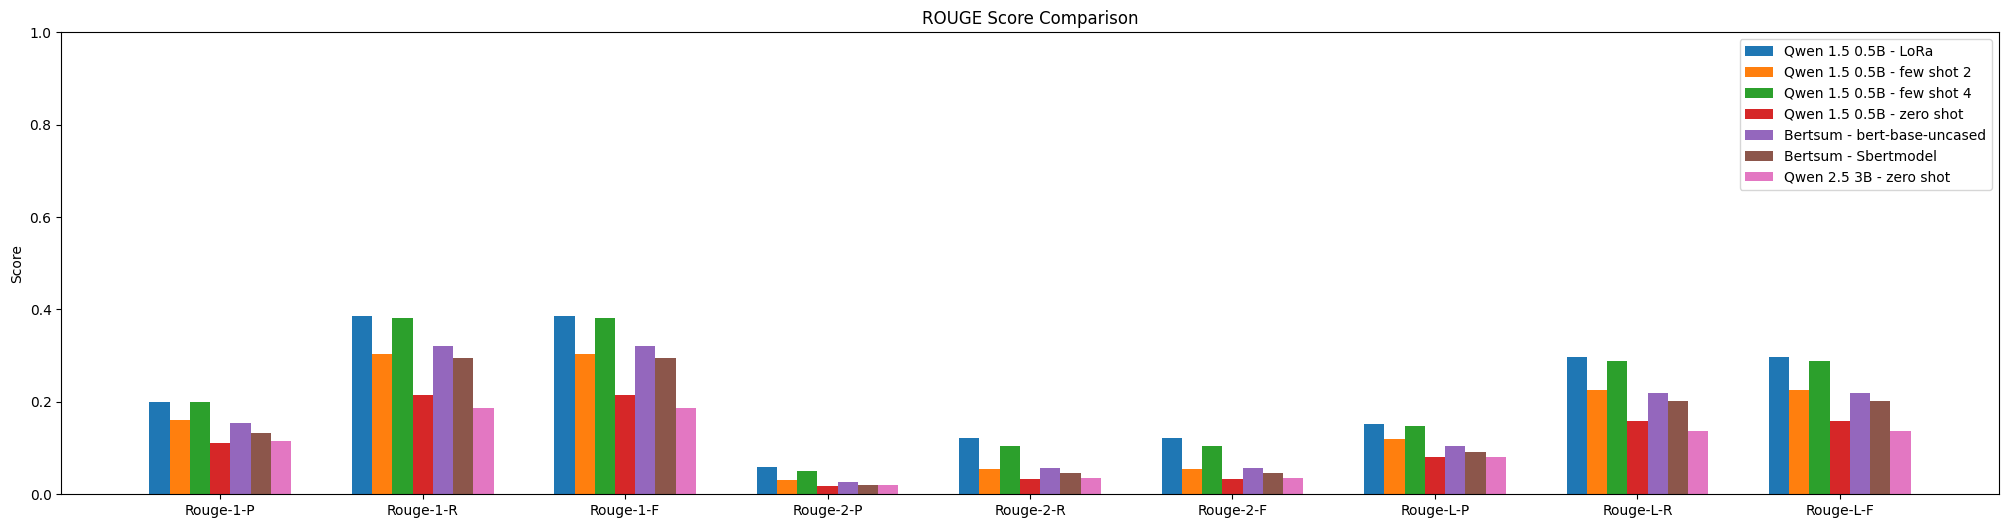

In [71]:
plot_data([data_ft, data_2,data_4, data_zero_shot, data_bertsum, data_bertsum_sbert, data_better])


In [55]:
import random
random_index = random.randint(0, len(ds["test"]) - 1)
showcase_dataset = ds["test"].select([0])
showcase_loader = DataLoader(showcase_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
batch = next(iter(showcase_loader))
print(f"Document: {batch['document'][0]}")
print(f"Target: {batch['summary'][0]}")
print("Qwuen 1.5 0.5B zero shot:")
evaluate_model(model, showcase_loader , device='cuda', bert=False, tokenizer=tokenizer, prompt=prompt0, promptsuff = "[AGENT]", prints = True)
print("Qwuen 1.5 0.5B two shot:")
evaluate_model(model, showcase_loader , device='cuda', bert=False, tokenizer=tokenizer, prompt=prompt2, promptsuff = "[AGENT]", prints = True)
print("Qwuen 1.5 0.5B four shot:")
evaluate_model(model, showcase_loader , device='cuda', bert=False, tokenizer=tokenizer, prompt=prompt4, promptsuff = "[AGENT]", prints = True)
print("Qwuen 1.5 0.5B fine tuned:")
evaluate_model(ft_model, showcase_loader , device='cuda', bert=False, tokenizer=tokenizer, prompt=prompt0, promptsuff = "[AGENT]", prints = True)
print("Qwuen 2.5 3B zero shot:")
evaluate_model(model_better, showcase_loader , device='cuda', bert=False, tokenizer=tokenizer, prompt=prompt0, promptsuff = "[AGENT]", prints = True)

Document: A selection of your pictures of Scotland sent in between 6 and 13 January. Send your photos to scotlandpictures@bbc.co.uk or our Instagram at #bbcscotlandpics.
Target: All pictures are copyrighted.
Qwuen 1.5 0.5B zero shot:
Prediction: Pictures of Scotland from the past 12 months are being uploaded to BBC Scotland's Instagram account. You can also check out our photo gallery. All photos are copyright of the source and are for educational purposes only. You can see more pictures on our
{'Rouge-1-P': 0.06666666666666667, 'Rouge-1-R': 0.75, 'Rouge-1-F': 0.75, 'Rouge-2-P': 0.0, 'Rouge-2-R': 0.0, 'Rouge-2-F': 0.0, 'Rouge-L-P': 0.044444444444444446, 'Rouge-L-R': 0.5, 'Rouge-L-F': 0.5}
Qwuen 1.5 0.5B two shot:
Prediction: You can now submit your pictures of Scotland to the BBC's Scotland Pictures page. We will post them on our website and on social media, and you can vote for your favourite in the competition.
You can also submit your own pictures by emailing scotland
{'Rouge-1-P': 

KeyboardInterrupt: 